# Збір даних

Для аналізу повітряних тривог я використовуватиму повідомлення з телеграм-каналу "Новости Одесса".  
За допомогою бібліотеки **telethon** я підключаюсь до свого облікового запису Telegram і вивантажую багато повідомлень (емпіричним шляхом я визначив, що за останній рік було близько 20k повідомлень).

In [1]:
import csv
from telethon.sync import TelegramClient
from tqdm import tqdm

Тут використовуються асинхронні операції, тобто такі, які можуть займати час (наприклад, отримання повідомлень з тг-каналу або взаємодія з API), вони виконуються паралельно без очікування результату. Це дозволяє програмі не блокуватись під час виконання тривалих операцій і продовжувати виконання інших задач в цей час. У даному випадку використання асинхронності важливо через велику кількість повідомлень, які потрібно отримати з тг-каналу.

In [2]:
# дані вашого облікового запису (підставте свої значення)
api_id = 'YOUR_API_ID'
api_hash = 'YOUR_API_HASH'
session_name = "session_name"

async def main():
    async with TelegramClient(session_name, api_id, api_hash) as client:
        # запустити клієнта
        await client.start()

        # записати повідомлення в файл
        with open("RAW_TEXT.csv", 'w', newline='', encoding='utf-8') as csvfile:
            fieldnames = ['Дата', 'Текст']
            writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
            writer.writeheader()

            channel_name = 'our_odessa'
            num_of_messages = 20000

            # progress bar показує скільки вже повідомлень прочитано
            with tqdm(total=num_of_messages) as pbar:
                async for message in client.iter_messages(channel_name, limit=num_of_messages):
                    writer.writerow({'Дата': message.date, 'Текст': message.message})
                    pbar.update(1)

# викликати асинхронну функцію
await main()

Please enter your phone (or bot token): +380981038963
Please enter the code you received: 28539
Please enter your password: ········
Signed in successfully as Stanislav


100%|████████████████████████████████████████████████████████████████████████████| 20000/20000 [03:21<00:00, 99.45it/s]


# Очистка даних

In [2]:
import pandas as pd
import numpy as np
import random

from datetime import datetime
from math import sqrt
import re

In [4]:
# завантажити "сирі" дані
df = pd.read_csv("RAW_TEXT.csv")

# подивитись як виглядає датафрейм
df.head()

,Дата,Текст
0,2024-04-26 16:01:54+00:00,"На Одещині затримали військовослужбовця, який ..."
1,2024-04-26 14:53:21+00:00,❗️Також у зв'язку із змаганнями буде змінено м...
2,2024-04-26 14:50:24+00:00,❎ ОТБОЙ\n\nПрислать новость 👉 @our_odessabot\n...
3,2024-04-26 14:36:31+00:00,На даний час все чисто в наш бік\nㅤ \nНадіслат...
4,2024-04-26 14:20:09+00:00,🚨ВОЗДУШНАЯ ТРЕВОГА\n\nУгроза баллистики с Крым...


Telegram рахує фотографії як окремі пости, тому деякі пости в сирому датасеті мають NaN в полі "Текст".  
Видалимо такі записи.

In [5]:
# запам'ятати скільки записів було
previous_len = len(df)

# видалити записи з порожнім текстом
df = df.loc[~pd.isna(df['Текст'])].reset_index(drop=True)

# подивитись скільки записів видалено
print(f"Видалено {previous_len - len(df)} рядків.")

Видалено 5391 рядків.


In [6]:
# подивитись коли було написано найдавніше повідомлення в датасеті
df.iloc[-1]

Дата                             2023-03-15 11:01:05+00:00
Текст    🚨ТРЕВОГА\n\nприслать новость 👉 @our_odessabot\...
Name: 14608, dtype: object

Розділимо повідомлення на ті, які відносяться до тривог і повідомлення на інші теми.  
Кожен початок тривоги в цьому тг-каналі позначають повідомленням **"🚨 ТРЕВОГА"**, а відбій повідомленням **"❎ ОТБОЙ"**.  
Вважатимемо всі повідомлення між цими двома такими, що мають стосунок до поточної тривоги, а ті що поза такою "рамкою" відкинемо.

In [7]:
# допоміжна колонка is_alert показує чи відноситься повідомлення до тривоги
if 'is_alert' not in df.columns:
    df['is_alert'] = pd.NA

# допоміжна змінна показує чи належить поточний запис до тривоги
current_is_alert = False

# повідомлення в файлі записані у зворотньому хронологічному порядку
for i in range(len(df) - 1, -1, -1):
    # поточне повідомлення
    current_text = str(df.at[i, 'Текст'])

    # початок тривоги
    if "🚨" in current_text and ("ТРЕВОГА" in current_text or "ТРИВОГА" in current_text):
        current_is_alert = True

    df.at[i, 'is_alert'] = current_is_alert

    # кінець тривоги
    if "❎" in current_text and ("ОТБОЙ" in current_text or "ВІДБІЙ" in current_text):
        current_is_alert = False


# подивитись як виглядає датафрейм
df.head()

,Дата,Текст,is_alert
0,2024-04-26 16:01:54+00:00,"На Одещині затримали військовослужбовця, який ...",False
1,2024-04-26 14:53:21+00:00,❗️Також у зв'язку із змаганнями буде змінено м...,False
2,2024-04-26 14:50:24+00:00,❎ ОТБОЙ\n\nПрислать новость 👉 @our_odessabot\n...,True
3,2024-04-26 14:36:31+00:00,На даний час все чисто в наш бік\nㅤ \nНадіслат...,True
4,2024-04-26 14:20:09+00:00,🚨ВОЗДУШНАЯ ТРЕВОГА\n\nУгроза баллистики с Крым...,True


In [8]:
# запам'ятати скільки записів було
previous_len = len(df)

# видалити рядки, які не належать до тривоги
df = df.loc[df['is_alert'] == True].reset_index(drop=True)

# видалити допоміжну колонку is_alert
df = df.drop(columns=['is_alert'])

# подивитись скільки записів видалено
print(f"Видалено {previous_len - len(df)} рядків.")

Видалено 8841 рядків.


Для зручності об'єднаємо повідомлення, які належать до однієї тривоги в один текст.

In [9]:
# створити новий датасет
df2 = pd.DataFrame(columns=["Текст", "Початок тривоги", "Кінець тривоги"])

# загальний текст поточної тривоги
current_alert_text = ""

# час початку поточної тривоги
current_alert_start_time = ""

# час закінчення поточної тривоги
current_alert_end_time = ""


for i in range(len(df) - 1, -1, -1):
    # поточне повідомлення
    current_text = str(df.at[i, 'Текст'])

    # перше повідомлення за всю тривогу
    if "🚨" in current_text and ("ТРЕВОГА" in current_text or "ТРИВОГА" in current_text):
        current_alert_start_time = str(df.at[i, 'Дата'])
        current_alert_text += current_text

    # останнє повідомлення за всю тривогу
    elif "❎" in current_text and ("ОТБОЙ" in current_text or "ВІДБІЙ" in current_text):
        current_alert_text += current_text
        current_alert_end_time = str(df.at[i, 'Дата'])

        # додати новий запис в кінець датасету
        df2.loc[len(df2)] = {"Текст": current_alert_text, "Початок тривоги": current_alert_start_time, "Кінець тривоги": current_alert_end_time}
        current_alert_text = ""

    # проміжні повідомлення
    else:
        current_alert_text += current_text


# подивитись як виглядає датафрейм
df2.head()

,Текст,Початок тривоги,Кінець тривоги
0,🚨ТРЕВОГА\n\nприслать новость 👉 @our_odessabot\...,2023-03-15 11:01:05+00:00,2023-03-15 11:18:29+00:00
1,🚨ТРЕВОГА\n\nПричина тревоги та же\n\nприслать ...,2023-03-15 13:04:31+00:00,2023-03-15 13:54:07+00:00
2,🚨ТРЕВОГА\n\nприслать новость 👉 @our_odessabot\...,2023-03-16 07:06:27+00:00,2023-03-16 08:37:46+00:00
3,🚨ТРЕВОГА\n\nприслать новость 👉 @our_odessabot\...,2023-03-18 07:10:11+00:00,2023-03-18 09:17:41+00:00
4,🚨ТРЕВОГА\n\nприслать новость 👉 @our_odessabot\...,2023-03-20 07:10:49+00:00,2023-03-20 08:42:18+00:00


In [10]:
len(df2)

609

In [11]:
# подивитись випадковий текст тривоги
random.choice(df2["Текст"])

'🚨ТРЕВОГА\n\nприслать новость 👉 @our_odessabot\n👉ПодписатьсяСтаном на зараз у повітрі декілька МіГ-31к та 1 літак-заправник Іл-78.\n\nЗліт відбувся з ае «Моздок» та ае «Саваслейка».\n\nВектор руху МіГ-31к - акваторія Чорного моря.\n\nСтежимо - https://t.me/+fzSnqEqdOck3Mjky\n\nНадіслати новину @our_odessabot\n👉 ПІДПИСАТИСЯ11.17, масштабна тривога триває.\n\nНаразі в небі 3х МІГи31К\n\nПусків не було, але вірогідність існує.\n\nБудьте обережні.\n\nНадіслати новину @our_odessabot\n👉 ПІДПИСАТИСЯ❎ ОТБОЙ\n\nприслать новость 👉 @our_odessabot\n👉Подписаться'

Нас цікавлять саме тривоги пов'язані з шахедами.  
Використаємо ключові слова типу "шахед", "мопед" і т.п. для пошуку відповідних тривог, а решту відкинемо.

In [12]:
# ключові слова пов'язані з шахедами
moped_keywords = ["мопед", "шахед", "шахид", "шахід", "дрон", "камікадзе", "камикадзе", "бпла", "безпілотник", "безпилотник"]

# допоміжна колонка is_moped показує чи пов'язана тривога з мопедами
if 'is_moped' not in df2.columns:
    df2['is_moped'] = pd.NA


for i in range(len(df2)):
    # допоміжна змінна показує чи пов'язана поточна тривога з мопедами
    current_is_moped = False

    # текст поточної тривоги
    current_text = str(df2.at[i, 'Текст']).lower()

    for k in moped_keywords:
        # перевірити чи зустрічається ключове слово в тексті тривоги
        if k in current_text:
            current_is_moped = True
            break

    df2.at[i, 'is_moped'] = current_is_moped


# подивитись як виглядає датафрейм
df2.head()

,Текст,Початок тривоги,Кінець тривоги,is_moped
0,🚨ТРЕВОГА\n\nприслать новость 👉 @our_odessabot\...,2023-03-15 11:01:05+00:00,2023-03-15 11:18:29+00:00,False
1,🚨ТРЕВОГА\n\nПричина тревоги та же\n\nприслать ...,2023-03-15 13:04:31+00:00,2023-03-15 13:54:07+00:00,False
2,🚨ТРЕВОГА\n\nприслать новость 👉 @our_odessabot\...,2023-03-16 07:06:27+00:00,2023-03-16 08:37:46+00:00,False
3,🚨ТРЕВОГА\n\nприслать новость 👉 @our_odessabot\...,2023-03-18 07:10:11+00:00,2023-03-18 09:17:41+00:00,False
4,🚨ТРЕВОГА\n\nприслать новость 👉 @our_odessabot\...,2023-03-20 07:10:49+00:00,2023-03-20 08:42:18+00:00,False


In [13]:
# запам'ятати скільки записів було
previous_len = len(df2)

# видалити тривоги які не пов'язані з шахедами
df2 = df2.loc[df2['is_moped'] == True].reset_index(drop=True)

# видалити допоміжну колонку
df2 = df2.drop(columns=['is_moped'])

# подивитись скільки записів видалено
print(f"Видалено {previous_len - len(df2)} рядків.")

Видалено 397 рядків.


Нас не цікавить весь текст тривоги, нам треба тільки виділити географічні назви населених пунктів, для яких була загроза під час даної тривоги.  
Було б зручно використати готовий список міст з інтернету, але в повідомленнях в телеграм часто використовуються неформальні назви (наприклад Поскот замість Житловий масив імені Котовського).  
На щастя, населених пунктів, які згадуються в більшості повідомлень про тривогу відносно невелика кількість, можна їх явно перерахувати.

In [14]:
# північ Одеської області
geo_north = "любашівка любашевка іванівка ивановка ширяєве ширяево балта первомайськ первомайск южноукраїнськ южноукраинск вознесенськ вознесенск роздільна раздельная ананьїв ананьев березівка березовка вінниця винница доброслав слободка слобідка"

# трохи північніше Одеси
geo_above_odesa = "кінбурнська кінбурн кинбурнская гвардійське гвардейское біляри білярі беляры рибаківка рыбаковка очаків очаков южне южное южний южный миколаїв николаев коблево коблеве першотравневе первомайское"

# район Одеси
geo_odesa = "авангард великодолинське великодолинское латівка латовка куяльник черьомушки черемушки паланка хлібодарське хлебодарское ланжерон лузанівка лузановка котовского котовського березань балка дачне дачное дальник шкільний школьный усатове усатово лиманка молдаванка поскот аркадія аркадия біляївка беляевка маяки гідропорт гидропорт пересип пересыпь центр чабанка фонтанка таїрове таирово одеса одесса"

# трохи південніше Одеси
geo_behind_odesa = "грибівка грибовка кароліно бугаз каролино курортне курортное чорноморськ черноморск затока аккерман білгород белгород санжейка санжійка сергіївка сергеевка"

# південь Одеської області
geo_south = "арциз рені рени приморське приморское болград орлівка орловка сарата зміїний змеиный лебедівка лебедевка вілково вілкове вилково вилкове татарбунари татарбунары кілія килия ізмаїл измаил"

In [15]:
# лематизувати слова - відкинути закінчення, щоб не розглядати різні відмінки слова як різні слова
endings = ["а", "и", "о", "е", "і", "я", "у", "ї", "ю", "є", "й", "ь", "ы"]

def remove_endings(word):
    """ Функція видаляє з кінця слова літери закінчення. """
    while len(word) > 0 and word[-1] in endings:
        word = word[:-1]
    return word


# об'єднати назви населених пунктів
geo_odesa_region = " ".join([geo_north, geo_above_odesa, geo_odesa, geo_behind_odesa, geo_south])

# розбити на окремі слова
geo_odesa_region = geo_odesa_region.split()

# відкинути закінчення
geo_odesa_region = list(set([remove_endings(geo) for geo in geo_odesa_region]))

print(f"Всього {len(geo_odesa_region)} населених пунктів.")

Всього 116 населених пунктів.


In [16]:
# створити окрему колонку для знайдених топонімів
if 'Гео' not in df2.columns:
    df2['Гео'] = pd.NA


for i in range(len(df2)):
    # текст поточної тривоги
    current_text = str(df2.at[i, 'Текст']).lower()

    # розділити текст на окремі слова без розділових знаків
    words = re.findall(r'\b\w+\b', current_text)

    # знайти топоніми в тексті
    df2.at[i, 'Гео'] = [remove_endings(word) for word in words if remove_endings(word.lower()) in geo_odesa_region]


# подивитись як виглядає датафрейм
df2.head()

,Текст,Початок тривоги,Кінець тривоги,Гео
0,🚨ТРЕВОГА\n\nприслать новость 👉 @our_odessabot\...,2023-03-21 17:32:08+00:00,2023-03-21 18:15:01+00:00,"[заток, беляевк, одесс, одесс, одесс, заток, т..."
1,🚨ТРЕВОГА\n\nприслать новость 👉 @our_odessabot\...,2023-04-03 22:23:20+00:00,2023-04-04 00:14:35+00:00,"[очаков, николаев, одесс, одес]"
2,🚨ТРЕВОГА\n\nприслать новость 👉 @our_odessabot\...,2023-04-04 09:41:29+00:00,2023-04-04 11:43:11+00:00,[одес]
3,🚨ТРЕВОГА\n\nАктивність ворожої авіації в морі....,2023-04-18 22:47:37+00:00,2023-04-18 23:59:38+00:00,"[чорноморськ, одес, одес, одес, таїров]"
4,"🚨ТРЕВОГА\n\nПодтверждения пусков пока нет, тре...",2023-05-01 00:14:24+00:00,2023-05-01 03:35:26+00:00,[]


In [17]:
# запам'ятати скільки записів було
previous_len = len(df2)

# видалити записи які не містять назв населених пунктів Одещини
df2 = df2[df2['Гео'].apply(lambda x: len(x) > 0)]

# видалити колонку "Текст"
df2 = df2.drop(columns=['Текст']).reset_index(drop=True)

# подивитись скільки записів видалено
print(f"Видалено {previous_len - len(df2)} рядків.")

Видалено 34 рядків.


Для аналізу нас не цікавить час закінчення тривоги. Зручніше було б розглянути тривалість тривоги.  
Знаючи тривалість тривоги і час початку можна за необхідності обчислити час закінчення.

In [18]:
# створити колонку
if 'Тривалість тривоги' not in df2.columns:
    df2['Тривалість тривоги'] = pd.NA


for i in range(len(df2)):
    # час початку тривоги
    start_time_str = df2.at[i, 'Початок тривоги']
    start_time = datetime.fromisoformat(start_time_str)

    # час завершення тривоги
    end_time_str = df2.at[i, 'Кінець тривоги']
    end_time = datetime.fromisoformat(end_time_str)

    # різниця в часі з точністю до хвилини
    duration_minutes = round((end_time - start_time).total_seconds() / 60)
    df2.at[i, 'Тривалість тривоги'] = duration_minutes


# подивитись як виглядає датафрейм
df2.head()

,Початок тривоги,Кінець тривоги,Гео,Тривалість тривоги
0,2023-03-21 17:32:08+00:00,2023-03-21 18:15:01+00:00,"[заток, беляевк, одесс, одесс, одесс, заток, т...",43
1,2023-04-03 22:23:20+00:00,2023-04-04 00:14:35+00:00,"[очаков, николаев, одесс, одес]",111
2,2023-04-04 09:41:29+00:00,2023-04-04 11:43:11+00:00,[одес],122
3,2023-04-18 22:47:37+00:00,2023-04-18 23:59:38+00:00,"[чорноморськ, одес, одес, одес, таїров]",72
4,2023-05-03 23:36:26+00:00,2023-05-04 01:31:02+00:00,"[одес, латовк, одес, одес, пересип, центр, оде...",115


In [19]:
# видалити колонку
df2 = df2.drop(columns=['Кінець тривоги'])

# подивитись як виглядає очищений датафрейм
df2.head()

,Початок тривоги,Гео,Тривалість тривоги
0,2023-03-21 17:32:08+00:00,"[заток, беляевк, одесс, одесс, одесс, заток, т...",43
1,2023-04-03 22:23:20+00:00,"[очаков, николаев, одесс, одес]",111
2,2023-04-04 09:41:29+00:00,[одес],122
3,2023-04-18 22:47:37+00:00,"[чорноморськ, одес, одес, одес, таїров]",72
4,2023-05-03 23:36:26+00:00,"[одес, латовк, одес, одес, пересип, центр, оде...",115


In [20]:
# зберегти оброблені дані
df2.to_csv("preprocessed_data.csv", index=False)

# Кластеризація

In [21]:
from geopy.distance import geodesic
from geopy.exc import GeocoderServiceError, GeocoderUnavailable
from geopy.adapters import AdapterHTTPError
from geopy.geocoders import Nominatim
import matplotlib.pyplot as plt
from sklearn.manifold import MDS

import time

Вище я вручну виписав назви міст розділені по регіонам.
Якби міст було багато, то це був би досить трудомісткий процес.  
Цікаво, чи можна розділити міста по регіонам використовуючи алгоритми машинного навчання?  
В цьому блоці я вирішив використати метод кластеризації **K-середніх** для розділення міст по регіонах області.

In [22]:
# зчитати підготовлені дані
df3 = pd.read_csv("preprocessed_data.csv")

# після зчитування з файлу колонка "Гео" має тип str, переведемо його назад в list
df3["Гео"] = df3["Гео"].apply(lambda x: x.replace("['", "").replace("']", "").split("', '"))

# подивитись як виглядає датафрейм
df3.head()

,Початок тривоги,Гео,Тривалість тривоги
0,2023-03-21 17:32:08+00:00,"[заток, беляевк, одесс, одесс, одесс, заток, т...",43
1,2023-04-03 22:23:20+00:00,"[очаков, николаев, одесс, одес]",111
2,2023-04-04 09:41:29+00:00,[одес],122
3,2023-04-18 22:47:37+00:00,"[чорноморськ, одес, одес, одес, таїров]",72
4,2023-05-03 23:36:26+00:00,"[одес, латовк, одес, одес, пересип, центр, оде...",115


In [23]:
len(df3)

178

In [24]:
# залишити тільки ті гео, які зустрічались в тексті
actual_geo = []
for i in range(len(df3)):
    actual_geo += df3.iloc[i]["Гео"]

# подивитись скільки гео були зайвими
actual_geo = sorted(list(set(actual_geo)))
print(f"{len(geo_odesa_region) - len(actual_geo)} назв населених пунктів були зайвими.")

17 назв населених пунктів були зайвими.


Суть метода K-середніх полягає в тому, що ми беремо якусь ознаку, яку можна виміряти (в нашому випадку - відстань між містами), визначаємо "центроїди" - значення ознаки, навколо яких групуватимуться подібні значення за цієї ознакою. Набір подібних значень - кластер.  
Перш за все мені треба визначити відстані між кожною парою міст.  
Для цього я використаю бібіліотеку ***geopy***  

In [25]:
print(actual_geo)

['авангард', 'аккерман', 'ананьев', 'ананьїв', 'аркад', 'арциз', 'балк', 'балт', 'белгород', 'беляевк', 'березан', 'березовк', 'березівк', 'болград', 'бугаз', 'білгород', 'біляр', 'біляївк', 'великодолинськ', 'вилков', 'винниц', 'вознесенск', 'вознесенськ', 'вінниц', 'гидропорт', 'грибовк', 'гідропорт', 'дальник', 'дачн', 'доброслав', 'заток', 'зміїн', 'измаил', 'каролин', 'каролін', 'кил', 'кинбурнск', 'коблев', 'котовськог', 'курортн', 'кіл', 'кінбурн', 'кінбурнськ', 'ланжерон', 'латовк', 'латівк', 'лебедевк', 'лебедівк', 'лиманк', 'лузанівк', 'любашевк', 'любашівк', 'маяк', 'миколаїв', 'молдаванк', 'николаев', 'одес', 'одесс', 'орловк', 'орлівк', 'очаков', 'очаків', 'паланк', 'первомайськ', 'пересип', 'пересып', 'першотравнев', 'поскот', 'приморск', 'приморськ', 'раздельн', 'рен', 'рибаківк', 'роздільн', 'рыбаковк', 'санжейк', 'сарат', 'сергеевк', 'сергіївк', 'слободк', 'таиров', 'татарбунар', 'таїров', 'усатов', 'фонтанк', 'хлібодарськ', 'центр', 'чабанк', 'черноморск', 'черьомушк'

Бібліотека ***geopy*** не приймає лематизовані гео, тому треба спочатку звести їх до повної назви.  
Оскільки гео у нас небагато, то найпростіший спосіб - занести цей список в **chatGPT** і попросити його видати повні назви.  
Він непогано впорався, але були певні неточності з закінченнями слів, які я підправив вручну.  
Назви міст які не відносяться до Одеської області я позначив плюсиком, це знадобиться для більш точного пошуку координат.

In [26]:
# повні назви міст отримані за допомогою chatGPT
full_geo_names = [
    'Авангард', 'Аккерман', 'Ананьев', 'Ананьїв', 'Аркадія', 'Арциз', 'Балка', 'Балта', 'Белгород-Дністровський', 'Беляевка', 'Березань', 'Березовка', 
    'Березівка', 'Болград', 'Бугаз', 'Білгород-Дністровський', 'Біляри', 'Біляївка', 'Великодолинське', 'Вилково', '+Винница', '+Вознесенск', '+Вознесенськ', 
    '+Вінниця', 'Гидропорт', 'Грибовка', 'Гідропорт', 'Дальник', 'Дачное', 'Доброслав', 'Затока', 'Зміїний', 'Ізмаїл', 'Каролино-Бугаз', 'Кароліно-Бугаз', 
    'Кілія', '+Кінбурнська коса', '+Коблеве', 'Котовського', 'Курортне', 'Кілія', '+Кінбурнська коса', '+Кінбурнська коса', 'Ланжерон', 'Латівка', 'Латівка', 
    'Лебедевка', 'Лебедівка', 'Лиманка', 'Лузанівка', 'Любашевка', 'Любашівка', 'Маяки', '+Миколаїв', 'Молдаванка', '+Миколаїв', 'Одеса', 'Одеса',
    'Орловка', 'Орлівка', '+Очаків', '+Очаків', 'Паланка', 'Первомайське', 'Пересыпь', 'Пересип', 'Першотравневе', 'Котовського', 'Приморське', 
    'Приморське', 'Роздільна', 'Рені', '+Рибаківка', 'Роздільна', '+Рибаківка', 'Санжейка', 'Сарата', 'Сергеевка', 'Сергіївка', 'Слободка',
    'Таїрове', 'Татарбунари', 'Таїрове', 'Усатово', 'Фонтанка', 'Хлібодарське', 'Одеса', 'Чабанка', 'Чорноморськ', 'Черьомушки', 'Чорноморськ', 
    'Ширяєве', 'Шкільний', 'Шкільний', 'Южне', '+Южноукраїнськ', '+Южноукраїнськ', 'Іванівка', 'Ізмаїл'
]

Пошук відстаней між кожною парою міст потребує певного часу. Всього у нас 99^2 = 9801 таких пошуків (або 9801 / 60 = 163.4 хвилин, якщо 1 пошук = 1 секунда).  
Щоб оптимізувати час пошуку шукатимемо тільки значення для верхньої правої частини матриці відстаней (значення над головною діагоналлю). Клітинка на перетині певного рядка і певного стовпчика цієї матриці відповідає відстані між відповідними двома містами. Матриця симетрична відносно головної діагоналі, бо "відстань між А та Б" = "відстань між Б та А". На самій головній діагоналі стоять нулі (бо "відстань між А та А" = 0).

In [34]:
# створити об'єкт геокодера
geolocator = Nominatim(user_agent="geo_distance")


def get_distance_between_geos(geo1, geo2):
    """ Функція знаходить вістань в кілометрах між двома географічними точками. """
    
    # знаходимо правильно назву для географічних точок
    if geo1.startswith("+"):
        geo11 = geo1[1:]
        location1 = geolocator.geocode(f'{geo11}, Україна')
    else:
        location1 = geolocator.geocode(f'{geo1}, Одеська область, Україна')

    if geo2.startswith("+"):
        geo2 = geo2[1:]
        location2 = geolocator.geocode(f'{geo2}, Україна')
    else:
        location2 = geolocator.geocode(f'{geo2}, Одеська область, Україна')

    # отримати координати для географічних точок
    coords1 = (location1.latitude, location1.longitude)
    coords2 = (location2.latitude, location2.longitude)

    # обчислити відстань між ними
    return round(geodesic(coords1, coords2).kilometers, 1)


# порожня матриця відстаней між містами
distances = [[0 for i in range(len(full_geo_names))] for j in range(len(full_geo_names))]

# для відслідковування прогресу виведемо progress bar
# total = половина елементів матриці мінус елементи які належать головній діагоналі
with tqdm(total = (len(full_geo_names) ** 2)/2 - len(full_geo_names)/2) as pbar:
    for i in range(len(full_geo_names)):
        # перше гео
        geo1 = full_geo_names[i]
        for j in range(i+1, len(full_geo_names)):
            # друге гео
            geo2 = full_geo_names[j]
            
            try:
                # обчислити відстань між містами
                distances[i][j] = get_distance_between_geos(geo1, geo2)
            except (AdapterHTTPError, GeocoderServiceError, GeocoderUnavailable):
                # якщо сталась помилка з'єднання, то спробуємо ще раз трохи пізніше
                time.sleep(30)
                distances[i][j] = get_distance_between_geos(geo1, geo2)
                
            # оновити progress bar
            pbar.update(1)

        # записати проміжні результати в файл
        with open("distances.txt", 'a') as file:
            file.write(" ".join(map(str, distances[i])) + "\n")

100%|██████████████████████████████████████████████████████████████████████████| 4851/4851.0 [1:48:43<00:00,  1.34s/it]


In [45]:
# матриця відстаней між містами
distances = []

# прочитати збережені значення матриці
with open("distances.txt", 'r') as file:
    for row in file.readlines():
        distances.append(list(map(float, row.split())))

# заповнити половину матриці, яка під головною діагоналлю
for i in range(len(distances)):
    for j in range(i):
        distances[i][j] = distances[j][i]

# подивитись як виглядає матриця відстаней
print(distances)

[[0.0, 37.4, 147.0, 147.0, 12.1, 105.4, 10.4, 179.4, 37.4, 29.7, 17.7, 84.3, 84.3, 178.1, 47.0, 37.4, 36.2, 29.7, 14.1, 143.1, 346.4, 133.7, 133.7, 346.4, 13.8, 29.4, 13.8, 28.1, 12.8, 46.2, 47.0, 138.9, 185.8, 36.8, 36.8, 155.0, 71.5, 50.3, 18.2, 64.4, 155.0, 71.5, 71.5, 11.6, 113.9, 113.9, 79.8, 79.8, 10.4, 14.6, 153.7, 153.7, 26.7, 119.5, 7.7, 119.5, 9.2, 9.2, 147.2, 147.2, 73.2, 73.2, 59.8, 134.6, 9.6, 9.6, 72.4, 18.2, 131.5, 131.5, 59.5, 213.3, 58.9, 59.5, 58.9, 26.2, 88.6, 52.7, 52.7, 184.5, 11.9, 104.2, 11.9, 6.0, 21.7, 2.2, 9.2, 27.6, 19.0, 54.6, 19.0, 106.5, 10.0, 10.0, 40.9, 156.4, 156.4, 58.0, 185.8], [37.4, 0.0, 172.0, 172.0, 41.7, 73.9, 31.9, 201.7, 0.0, 32.5, 42.4, 120.3, 120.3, 146.0, 16.2, 0.0, 71.3, 32.5, 24.8, 105.8, 366.3, 170.6, 170.6, 366.3, 51.1, 17.0, 51.1, 14.8, 45.7, 83.6, 16.3, 104.6, 150.0, 14.8, 14.8, 118.3, 100.0, 84.4, 55.1, 28.6, 118.3, 100.0, 100.0, 45.1, 132.8, 132.8, 42.9, 42.9, 33.9, 51.5, 182.5, 182.5, 25.7, 153.5, 42.4, 153.5, 44.1, 44.1, 161.0, 161

In [46]:
def evklid_dist(x, y):
    """ Функція обчислює евклідову відань між точками x та y. """
    return sqrt(sum([(x[i] - y[i]) ** 2 for i in range(len(x))]))


# гео які використовуватимемо як початкові центроїди
first_centroid_cities = ["балт", "миколаїв", "одесс", "заток", "измаил"]

# координати поточних центроїдів
current_centroid_coords = [distances[actual_geo.index(geo)] for geo in first_centroid_cities]

# координати центроїдів з попередньої ітерації
previous_centroid_coords = [[0 for i in range(len(coord))] for coord in current_centroid_coords]

# лічильник ітерацій
cnt = 0

# повторюємо ітерації, поки координати центроїдів не перестануть змінюватись
while any([current_centroid_coords[i] != previous_centroid_coords[i] for i in range(len(first_centroid_cities))]):
   
    # запам'ятати координати центроїдів з попередньої ітерації
    previous_centroid_coords = [coord.copy() for coord in current_centroid_coords]

    # очистити значення поточних координат центроїдів та склади кластерів, щоб заповнити їх новими
    current_centroid_coords = []
    
    # кластери - набори міст, найближчих до кожного центроїда
    clusters = [[] for i in range(len(first_centroid_cities))]

    for i in range(len(actual_geo)):
        # координати поточного гео
        current_town = distances[i]

        # відстань від поточного гео до центроїдів
        distance_to_centroids = [evklid_dist(current_town, centroid) for centroid in previous_centroid_coords]

        # визначити до якого центроїда дане місто найближче, в той кластер його додаємо
        M = min(distance_to_centroids)
        centroid_idx = distance_to_centroids.index(M)
        clusters[centroid_idx].append(current_town)

    # обчислити нові координати центроїдів = середнє арифметичне координат міст які належать кластеру
    current_centroid_coords = [[sum([cluster[j][i] for j in range(len(cluster))]) / len(cluster) for i in range(len(cluster[0]))] for cluster in clusters]
    cnt += 1


# подивитись результати
print(f"Всього {cnt} ітерацій\n")
for i in range(len(first_centroid_cities)):
    print(full_geo_names[actual_geo.index(first_centroid_cities[i])])
    print([actual_geo[distances.index(t)] for t in clusters[i]])
    print()

Всього 3 ітерацій

Балта
['ананьев', 'ананьев', 'балт', 'винниц', 'винниц', 'латовк', 'латовк', 'любашевк', 'любашевк', 'орловк', 'орловк', 'первомайськ', 'слободк', 'южноукраинск', 'южноукраинск']

+Миколаїв
['березовк', 'березовк', 'вознесенск', 'вознесенск', 'кинбурнск', 'кинбурнск', 'кинбурнск', 'миколаїв', 'миколаїв', 'очаков', 'очаков', 'рибаківк', 'рибаківк', 'ширяєв']

Одеса
['авангард', 'аркад', 'балк', 'беляевк', 'березан', 'біляр', 'беляевк', 'великодолинськ', 'гидропорт', 'гидропорт', 'дачн', 'доброслав', 'коблев', 'котовськог', 'ланжерон', 'лиманк', 'лузанівк', 'маяк', 'молдаванк', 'одес', 'одес', 'пересип', 'пересип', 'першотравнев', 'котовськог', 'раздельн', 'раздельн', 'санжейк', 'таиров', 'таиров', 'усатов', 'фонтанк', 'хлібодарськ', 'одес', 'чабанк', 'черноморск', 'черьомушк', 'черноморск', 'школьн', 'школьн', 'южн', 'іванівк']

Затока
['аккерман', 'арциз', 'аккерман', 'бугаз', 'аккерман', 'грибовк', 'дальник', 'заток', 'каролин', 'каролин', 'курортн', 'лебедевк', 'ле

Було б добре візуалізувати міста як точки на графіку і явно побачити кластери.  
Наші "точки" мають 99-вимірні координати, тому зобразити їх на пласкому графіку ми не зможемо.  
Скористаємось методом **MDS** (Multi-Dimensional Scaling), щоб зменшити розмірність наших даних до 2-вимірних.  
Основна ідея полягає в тому, щоб знайти наближені координати в просторі меншої розмірності для кожного об'єкта так, щоб вони якомога краще відображали відстані між об'єктами у вихідному просторі вищої розмірності.

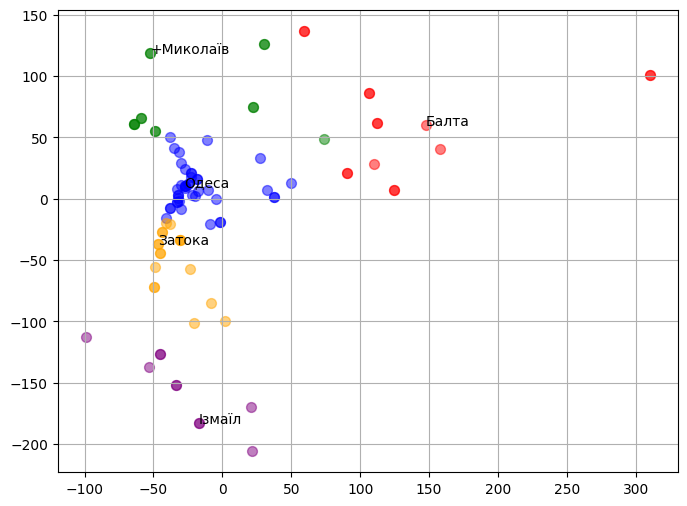

In [47]:
# створити об'єкт MDS
mds = MDS(n_components=2, dissimilarity='precomputed', normalized_stress='auto')

# зменшити розмірність координат
coordinates = mds.fit_transform(distances)

# створити графік
plt.figure(figsize=(8, 6))

# набір кольорів для різних кластерів
colors = ["red", "green", "blue", "orange", "purple", "yellow", "black","pink", "brown"]

for i in range(len(clusters)):
    # поточний кластер
    cluster = clusters[i]

    # знайти 2-вимірні координати поточного кластера
    two_dim_cluster = [coordinates[distances.index(cluster[j])] for j in range(len(cluster))]

    # зобразити на графіку точки, які належать поточному кластеру
    plt.scatter([x[0] for x in two_dim_cluster], [x[1] for x in two_dim_cluster], c=colors[i % len(clusters)], s=50, alpha=0.5)


# додати назви центроїдів на графік
for i in range(len(first_centroid_cities)):
    # 2-вимірні координати поточного центроїда
    centr_coords = coordinates[actual_geo.index(first_centroid_cities[i])]

    # знайти повну назву поточного центроїда
    label = full_geo_names[actual_geo.index(first_centroid_cities[i])]

    # додати назву поточного центроїда на графік
    plt.text(centr_coords[0], centr_coords[1], label, fontsize=10)


# додати сітку
plt.grid(True)
plt.show()

Подивимось наскільки розподіл міст за методом K-середніх відрізняється від того як я розподілив вручну.

In [48]:
# список виписаних раніше гео
geo_north_lst = list(set([remove_endings(geo) for geo in geo_north.split() if remove_endings(geo) in actual_geo]))
geo_above_odesa_lst = list(set([remove_endings(geo) for geo in geo_above_odesa.split() if remove_endings(geo) in actual_geo]))
geo_odesa_lst = list(set([remove_endings(geo) for geo in geo_odesa.split() if remove_endings(geo) in actual_geo]))
geo_behind_odesa_lst = list(set([remove_endings(geo) for geo in geo_behind_odesa.split() if remove_endings(geo) in actual_geo]))
geo_south_lst = list(set([remove_endings(geo) for geo in geo_south.split() if remove_endings(geo) in actual_geo]))

In [49]:
# знайдені раніше кластери, у вигляді назв гео, а не координат
clusters_names = [[actual_geo[distances.index(cluster[i])] for i in range(len(cluster))] for cluster in clusters]

# для кожного регіону шукаємо долю співпадінь в поділі на регіони вручну та методом K-середніх
print("Співпадіння:")
print("Північ -", str(round(len(set(geo_north_lst).intersection(set(clusters_names[0]))) / len(geo_north_lst) * 100, 2)) + " %")
print("Вище Одеси -", str(round(len(set(geo_above_odesa_lst).intersection(set(clusters_names[1]))) / len(geo_above_odesa_lst) * 100, 2)) + " %")
print("Одеса -", str(round(len(set(geo_odesa_lst).intersection(set(clusters_names[2]))) / len(geo_odesa_lst) * 100, 2)) + " %")
print("Нижче Одеси -", str(round(len(set(geo_behind_odesa_lst).intersection(set(clusters_names[3]))) / len(geo_behind_odesa_lst) * 100, 2)) + " %")
print("Південь -", str(round(len(set(geo_south_lst).intersection(set(clusters_names[4]))) / len(geo_south_lst) * 100, 2)) + " %")

Співпадіння:
Північ - 35.0 %
Вище Одеси - 30.77 %
Одеса - 65.71 %
Нижче Одеси - 50.0 %
Південь - 41.18 %


Результат методу K-середніх досить переконливий, але я все ж працюватиму далі зі своїм початковим розбиттям.

Я не маю даних скільки саме шахедів в якому напрямку летіло.  
Замість цього використаємо "гібридну" змінну: припустимо, що кількість згадок в межах даної тривоги гео які належать до даного регіону прямо пропорційна ступеню небезпеки для даного регіону.  
Вважатимемо, що основною ціллю кожної атаки є один конкретний регіон.

In [50]:
# додати колонку
if 'Регіон атаки' not in df3.columns:
    df3['Регіон атаки'] = pd.NA


for i in range(len(df3)):
    # лічильник згадок кожного регіону
    regions = {
        "north": 0,
        "above_odesa": 0,
        "odesa": 0,
        "behind_odesa": 0,
        "south": 0
    }

    # список поточних гео
    geo = df3.at[i, 'Гео']

    for g in geo:
        if g in geo_north_lst: regions["north"] += 1
        elif g in geo_above_odesa_lst: regions["above_odesa"] += 1
        elif g in geo_odesa_lst: regions["odesa"] += 1
        elif g in geo_behind_odesa_lst: regions["behind_odesa"] += 1
        elif g in geo_south_lst: regions["south"] += 1

    # ціль атаки = регіон, який згадувався найчастіше
    df3.at[i, 'Регіон атаки'] = [k for k in regions.keys() if regions[k] == max(regions.values())][0]


# колонка з набором гео нам більше не потрібна
df3 = df3.drop(columns=['Гео'])

# подивитись як виглядає датафрейм
df3.head()

,Початок тривоги,Тривалість тривоги,Регіон атаки
0,2023-03-21 17:32:08+00:00,43,odesa
1,2023-04-03 22:23:20+00:00,111,above_odesa
2,2023-04-04 09:41:29+00:00,122,odesa
3,2023-04-18 22:47:37+00:00,72,odesa
4,2023-05-03 23:36:26+00:00,115,odesa


Сам по собі час початку тривоги для аналізу не дуже зручний. Нас скоріше цікавить скільки часу пройшло між тривогами.

In [51]:
# час початку наступної тривоги = час початку поточної з лагом 1
df3['Наступна тривога'] = df3['Початок тривоги'].shift(-1)

# подивитись як виглядає датафрейм
df3.head()

,Початок тривоги,Тривалість тривоги,Регіон атаки,Наступна тривога
0,2023-03-21 17:32:08+00:00,43,odesa,2023-04-03 22:23:20+00:00
1,2023-04-03 22:23:20+00:00,111,above_odesa,2023-04-04 09:41:29+00:00
2,2023-04-04 09:41:29+00:00,122,odesa,2023-04-18 22:47:37+00:00
3,2023-04-18 22:47:37+00:00,72,odesa,2023-05-03 23:36:26+00:00
4,2023-05-03 23:36:26+00:00,115,odesa,2023-05-06 19:37:42+00:00


In [52]:
# видалити останній запис з датафрейму (бо там None)
df3 = df3.drop(df3.index[-1])

# обчислити різницю часу (з точністю до півгодини)
df3['Час до наступної тривоги'] = (pd.to_datetime(df3['Наступна тривога']) - pd.to_datetime(df3['Початок тривоги'])).apply(lambda x: int(x.total_seconds() / (30 * 60)))

# подивитись як виглядає датафрейм
df3.head()

,Початок тривоги,Тривалість тривоги,Регіон атаки,Наступна тривога,Час до наступної тривоги
0,2023-03-21 17:32:08+00:00,43,odesa,2023-04-03 22:23:20+00:00,633
1,2023-04-03 22:23:20+00:00,111,above_odesa,2023-04-04 09:41:29+00:00,22
2,2023-04-04 09:41:29+00:00,122,odesa,2023-04-18 22:47:37+00:00,698
3,2023-04-18 22:47:37+00:00,72,odesa,2023-05-03 23:36:26+00:00,721
4,2023-05-03 23:36:26+00:00,115,odesa,2023-05-06 19:37:42+00:00,136


In [53]:
# колонки з точним часом нам більше не потрібні
df3 = df3.drop(columns=['Початок тривоги', 'Наступна тривога'])

# подивитись як виглядає датафрейм
df3.head()

,Тривалість тривоги,Регіон атаки,Час до наступної тривоги
0,43,odesa,633
1,111,above_odesa,22
2,122,odesa,698
3,72,odesa,721
4,115,odesa,136


Такий датасет вже підходить для аналізу.

In [54]:
# збірігаємо підготовлений датасет
df3.to_csv("preprocessed_data_2.csv", index=False)

# Додаткова підготовка даних

Перед тим як передавати дані на вхід моделям машинного навчання вони потребують ще певної обробки.

In [55]:
from sklearn.preprocessing import StandardScaler

In [56]:
# зчитати підготовлені дані
df4 = pd.read_csv("preprocessed_data_2.csv")

# подивитись як виглядає датафрейм
df4.head()

,Тривалість тривоги,Регіон атаки,Час до наступної тривоги
0,43,odesa,633
1,111,above_odesa,22
2,122,odesa,698
3,72,odesa,721
4,115,odesa,136


Числові змінні можуть мати різну дисперсію. Чим більше розкид значень певної змінної тим більшу "вагу" вона матиме в кінцевій моделі.  
Для уникнення небажаного впливу дисперсії на результат стандартизуємо числові змінні шляхом Z-нормалізації (значення будуть відображатися у вигляді стандартних відхилень від середнього, а не в їхніх початкових одиницях вимірювання).

In [57]:
# створити об'єкт StandardScaler для змінної "Тривалість тривоги"
scaler_duration = StandardScaler()

# стандартизувати значення змінної "Тривалість тривоги"
df4['Тривалість тривоги'] = scaler_duration.fit_transform(df4['Тривалість тривоги'].values.reshape(-1, 1))

# створити об'єкт StandardScaler для змінної "Час до наступної тривоги"
scaler_time = StandardScaler()

# стандартизувати значення змінної "Час до наступної тривоги"
df4['Час до наступної тривоги'] = scaler_time.fit_transform(df4['Час до наступної тривоги'].values.reshape(-1, 1))

# подивитись як виглядає датафрейм
df4.head()

,Тривалість тривоги,Регіон атаки,Час до наступної тривоги
0,-0.951464,odesa,4.118155
1,-0.050314,above_odesa,-0.676244
2,0.095461,odesa,4.628197
3,-0.567150,odesa,4.808674
4,0.002695,odesa,0.218292


Інколи рекомендують розбивати категоріальні змінні на множину відповідних булевих змінних. Я спробую обидва підходи, подивимось як це вплине на результат.

In [58]:
# створити окремий датафрейм
df4_dummy = df4.copy()

# створити булеві змінні, які відповідають категоріальній змінній "Регіон атаки"
dummies = df4_dummy['Регіон атаки'].apply(lambda x: pd.Series([1] * len([x]), index=[x])).fillna(0).astype(int)

# додати ці булеві змінні в датафрейм
df4_dummy = pd.concat([df4_dummy, dummies], axis=1)

# видалити колонку "Регіон атаки", вона більше не потрібна
df4_dummy.drop('Регіон атаки', axis=1, inplace=True)

# подивитись як виглядає датафрейм
df4_dummy.head()

,Тривалість тривоги,Час до наступної тривоги,odesa,above_odesa,behind_odesa,north,south
0,-0.951464,4.118155,1,0,0,0,0
1,-0.050314,-0.676244,0,1,0,0,0
2,0.095461,4.628197,1,0,0,0,0
3,-0.567150,4.808674,1,0,0,0,0
4,0.002695,0.218292,1,0,0,0,0


In [59]:
# встановити правильний порядок колонок
new_order = ['Тривалість тривоги', 'Час до наступної тривоги', 'north', 'above_odesa', 'odesa', 'behind_odesa', 'south']
df4_dummy = df4_dummy.reindex(columns=new_order)

# подивитись як виглядає датафрейм
df4_dummy.head()

,Тривалість тривоги,Час до наступної тривоги,north,above_odesa,odesa,behind_odesa,south
0,-0.951464,4.118155,0,0,1,0,0
1,-0.050314,-0.676244,0,1,0,0,0
2,0.095461,4.628197,0,0,1,0,0
3,-0.567150,4.808674,0,0,1,0,0
4,0.002695,0.218292,0,0,1,0,0


Моделі машинного навчання приймають на вхід тільки числа. Тому треба "закодувати" категоріальну змінну "Регіон атаки": кожному значенню поставимо у відповідність певне число.

In [60]:
# словник чисел які відповідають кожному регіону
regions = {
    "north": 0,
    "above_odesa": 1,
    "odesa": 2,
    "behind_odesa": 3,
    "south": 4
}

# змінити рядки на числа в колонці "Регіон атаки"
for i in range(len(df4)):
    df4.loc[i, "Регіон атаки"] = regions[df4.loc[i, "Регіон атаки"]]

# подивитись як виглядає датафрейм
df4.head()

,Тривалість тривоги,Регіон атаки,Час до наступної тривоги
0,-0.951464,2,4.118155
1,-0.050314,1,-0.676244
2,0.095461,2,4.628197
3,-0.567150,2,4.808674
4,0.002695,2,0.218292


Для прогнозу ми використовуватимемо "історичні" дані. Тобто знаючи тривалість попередньої тривоги, який був основний регіон атаки та скільки пройшло часу до неї від тривоги, що їй передувала ми хочемо знати через скільки часу буде наступна тривога.

In [61]:
# створити окремий датафрейм
df5 = df4.copy()

# додати нову колонку, яка містить значення 'Час до наступної тривоги' з лагом 1
df5['Наступний час до наступної тривоги'] = df5['Час до наступної тривоги'].shift(-1)
df5 = df5.dropna()

# подивитись як виглядає датафрейм
df5.head()

,Тривалість тривоги,Регіон атаки,Час до наступної тривоги,Наступний час до наступної тривоги
0,-0.951464,2,4.118155,-0.676244
1,-0.050314,1,-0.676244,4.628197
2,0.095461,2,4.628197,4.808674
3,-0.567150,2,4.808674,0.218292
4,0.002695,2,0.218292,-0.472227


In [62]:
# повторю ті самі кроки для датафрейму з булевими змінними замість категоріальної

# створити окремий датафрейм
df5_dummy = df4_dummy.copy()

# додати нову колонку, яка містить значення 'Час до наступної тривоги' з лагом 1
df5_dummy['Наступний час до наступної тривоги'] = df5_dummy['Час до наступної тривоги'].shift(-1)
df5_dummy = df5_dummy.dropna()

# подивитись як виглядає датафрейм
df5_dummy.head()

,Тривалість тривоги,Час до наступної тривоги,north,above_odesa,odesa,behind_odesa,south,Наступний час до наступної тривоги
0,-0.951464,4.118155,0,0,1,0,0,-0.676244
1,-0.050314,-0.676244,0,1,0,0,0,4.628197
2,0.095461,4.628197,0,0,1,0,0,4.808674
3,-0.567150,4.808674,0,0,1,0,0,0.218292
4,0.002695,0.218292,0,0,1,0,0,-0.472227


# Регресія

Для регресії та класифікації я не буду детально розбирати алгоритми, замість цього використаю готові бібліотеки python.  
Основна мета цього проекту - ознайомитись з технологіями, спробувати їх використати і зробити висновок чи є вони корисними в роботі Дата аналітика. Якщо так, то далі слід розбиратись більш детально.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

Перш за все, було б круто знати коли почнеться наступна тривога.  
Для цього скористаємось регресійними алгоритмами машинного навчання, які повертають конкретне число (час до наступної тривоги).

In [63]:
# змінні-предиктори
X = df5[['Тривалість тривоги', 'Час до наступної тривоги', 'Регіон атаки']]
# цільова змінна
y = df5['Наступний час до наступної тривоги']

# розділяємо набір даних на вибірку для навчання та вибірку для тестування моделі
# переводимо їх з типу pd.Series в np.array (знадобиться для нейронних мереж)
X_train, X_test, y_train, y_test = map(np.float32, train_test_split(X, y, test_size=0.2, random_state=42))

In [64]:
# Лінійна регресія

# створити та навчити модель
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# прогнозування
predictions = lr_model.predict(X_test)

# оцінка результатів
mse = mean_squared_error(y_test, predictions)
print("Mean Squared Error:", mse)

Mean Squared Error: 0.846465


In [65]:
# Лінійна регресія з дихотомічними змінними

# змінні-предиктори
X_dummy = df5_dummy[['Тривалість тривоги', 'Час до наступної тривоги', 'north', 'above_odesa', 'odesa', 'behind_odesa', 'south']]
# цільова змінна
y_dummy = df5_dummy['Наступний час до наступної тривоги']

# розділити набір даних на вибірку для навчання та вибірку для тестування моделі
X_train_dummy, X_test_dummy, y_train_dummy, y_test_dummy = map(np.float32, train_test_split(X_dummy, y_dummy, test_size=0.2, random_state=42))

# створити та навчити модель
lr_model_dummy = LinearRegression()
lr_model_dummy.fit(X_train_dummy, y_train_dummy)

# прогнозування
predictions = lr_model_dummy.predict(X_test_dummy)

# оцінка результатів
mse = mean_squared_error(y_test_dummy, predictions)
print("Mean Squared Error:", mse)

Mean Squared Error: 0.7843025


In [66]:
# Decision Tree

# створити та навчити модель
dt_model = DecisionTreeRegressor()
dt_model.fit(X_train, y_train)

# прогнозування
predictions = dt_model.predict(X_test)

# оцінка результатів
mse = mean_squared_error(y_test, predictions)
print("Mean Squared Error:", mse)

Mean Squared Error: 1.3319795794888925


In [67]:
# Random Forest

# створити та навчити модель
rf_model = RandomForestRegressor()
rf_model.fit(X_train, y_train)

# прогнозування
predictions = rf_model.predict(X_test)

# оцінка результатів
mse = mean_squared_error(y_test, predictions)
print("Mean Squared Error:", mse)

Mean Squared Error: 0.8258349918437425


In [68]:
# Нейронна мережа

# створення та навчання моделі
nn_model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(64, activation='relu'),
    Dense(1)
])
nn_model.compile(optimizer='adam', loss='mse')
nn_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=1)

# прогнозування
predictions = nn_model.predict(X_test)

# оцінка результатів
mse = mean_squared_error(y_test, predictions)
print("Mean Squared Error:", mse)

Epoch 1/50
4/4 [==============================] - 1s 84ms/step - loss: 0.8881 - val_loss: 1.1566
Epoch 2/50
4/4 [==============================] - 0s 17ms/step - loss: 0.8409 - val_loss: 1.1500
Epoch 3/50
4/4 [==============================] - 0s 19ms/step - loss: 0.8197 - val_loss: 1.1568
Epoch 4/50
4/4 [==============================] - 0s 15ms/step - loss: 0.8163 - val_loss: 1.1690
Epoch 5/50
4/4 [==============================] - 0s 17ms/step - loss: 0.8107 - val_loss: 1.1726
Epoch 6/50
4/4 [==============================] - 0s 15ms/step - loss: 0.7988 - val_loss: 1.1589
Epoch 7/50
4/4 [==============================] - 0s 14ms/step - loss: 0.7913 - val_loss: 1.1521
Epoch 8/50
4/4 [==============================] - 0s 16ms/step - loss: 0.7899 - val_loss: 1.1463
Epoch 9/50
4/4 [==============================] - 0s 15ms/step - loss: 0.7804 - val_loss: 1.1500
Epoch 10/50
4/4 [==============================] - 0s 15ms/step - loss: 0.7778 - val_loss: 1.1560
Epoch 11/50
4/4 [============

In [69]:
# тестові значення
time_between_alerts_test = 142
alert_duration_test = 94
attack_region_test = "behind_odesa"

# стандартизувати тестові дані
t = scaler_time.transform([[time_between_alerts_test]])[0][0]        # time between alerts
d = scaler_duration.transform([[alert_duration_test]])[0][0]         # duration
r = [v for k, v in regions.items() if k == attack_region_test][0]    # region
r_dummy = [
    1 if attack_region_test == 'north' else 0,
    1 if attack_region_test == 'above_odesa' else 0,
    1 if attack_region_test == 'odesa' else 0,
    1 if attack_region_test == 'behind_odesa' else 0,
    1 if attack_region_test == 'south' else 0
]

# для кожної моделі порахувати прогноз і повернути результат в нестандартизованому вигляді
lr_model_prediction = lr_model.predict([[t, d, r]])
print("Linear Regression: ", scaler_time.inverse_transform(lr_model_prediction.reshape(-1, 1))[0][0])

lr_model_dummy_prediction = lr_model_dummy.predict([[t, d, *r_dummy]])
print("Linear Regression dummy: ", scaler_time.inverse_transform(lr_model_dummy_prediction.reshape(-1, 1))[0][0])

dt_model_prediction = dt_model.predict([[t, d, r]])
print("Decision Tree: ", scaler_time.inverse_transform(dt_model_prediction.reshape(-1, 1))[0][0])

rf_model_prediction = rf_model.predict([[t, d, r]])
print("Random Forest: ", scaler_time.inverse_transform(rf_model_prediction.reshape(-1, 1))[0][0])

nn_model_prediction = nn_model.predict([[t, d, r]], verbose=0)  # verbose=0 шоб не виводило progress bar
print("Neural Network Regressor: ", scaler_time.inverse_transform(nn_model_prediction.reshape(-1, 1))[0][0])

actual_value = df5.loc[(df5['Тривалість тривоги'] == d) & (df5['Час до наступної тривоги'] == t) & (df5['Регіон атаки'] == r), 'Наступний час до наступної тривоги'].values[0]
print("\nActual value: ", scaler_time.inverse_transform(actual_value.reshape(-1, 1))[0][0])

Linear Regression:  97.19582558094167
Linear Regression dummy:  71.22408218581029
Decision Tree:  51.00000116088989
Random Forest:  83.04999980106173
Neural Network Regressor:  152.69333

Actual value:  192.0


# Класифікація

Було б корисно також знати який регіон стане об'єктом наступної атаки ворога.  
Для такого прогнозування використаємо класифікаційні моделі машинного навчання, які повертають одне зі значень категоріальної змінної.

In [70]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

In [71]:
# створити окремий датафрейм
df6 = df4.copy()

# додати нову колонку, яка містить значення 'Регіон атаки' з лагом 1
df6['Регіон наступної атаки'] = df6['Регіон атаки'].shift(-1)
df6 = df6.dropna()

# подивитись як виглядає датафрейм
df6.head()

,Тривалість тривоги,Регіон атаки,Час до наступної тривоги,Регіон наступної атаки
0,-0.951464,2,4.118155,1
1,-0.050314,1,-0.676244,2
2,0.095461,2,4.628197,2
3,-0.567150,2,4.808674,2
4,0.002695,2,0.218292,1


In [72]:
# змінні-предиктори
X = df6[['Тривалість тривоги', 'Регіон атаки', 'Час до наступної тривоги']]
# цільова змінна
y = df6['Регіон наступної атаки']

# розділити дані на тренувальну та тестову вибірки
X_train, X_test, y_train, y_test = map(np.float32, train_test_split(X, y, test_size=0.2, random_state=42))

In [73]:
# Random Forest

# створити та навчити модель
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# прогнозування
y_pred_rf = rf_model.predict(X_test)

# оцінка точності моделі
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print("Accuracy of Random Forest:", accuracy_rf)

Accuracy of Random Forest: 0.2777777777777778


In [74]:
# Support Vector Machine

# створити та навчити модель
svm_model = SVC(kernel='linear', random_state=42)
svm_model.fit(X_train, y_train)

# прогнозування
y_pred_svm = svm_model.predict(X_test)

# оцінка точності моделі
accuracy_svm = accuracy_score(y_test, y_pred_svm)
print("Accuracy of SVM:", accuracy_svm)

Accuracy of SVM: 0.4166666666666667


In [75]:
# Нейронна мережа

# створити та навчити модель
nn_model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(64, activation='relu'),
    Dense(len(regions), activation='softmax') 
])
nn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
nn_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)

# оцінка точності моделі
test_loss, test_accuracy = nn_model.evaluate(X_test, y_test)
print("Test Accuracy:", test_accuracy)

Epoch 1/50
4/4 [==============================] - 1s 73ms/step - loss: 1.5396 - accuracy: 0.2857 - val_loss: 1.5001 - val_accuracy: 0.5000
Epoch 2/50
4/4 [==============================] - 0s 18ms/step - loss: 1.4842 - accuracy: 0.4732 - val_loss: 1.4208 - val_accuracy: 0.5714
Epoch 3/50
4/4 [==============================] - 0s 17ms/step - loss: 1.4508 - accuracy: 0.5000 - val_loss: 1.3709 - val_accuracy: 0.6071
Epoch 4/50
4/4 [==============================] - 0s 17ms/step - loss: 1.4394 - accuracy: 0.5000 - val_loss: 1.3433 - val_accuracy: 0.6071
Epoch 5/50
4/4 [==============================] - 0s 16ms/step - loss: 1.4258 - accuracy: 0.5000 - val_loss: 1.3355 - val_accuracy: 0.6071
Epoch 6/50
4/4 [==============================] - 0s 17ms/step - loss: 1.4161 - accuracy: 0.5000 - val_loss: 1.3306 - val_accuracy: 0.6071
Epoch 7/50
4/4 [==============================] - 0s 15ms/step - loss: 1.4054 - accuracy: 0.5000 - val_loss: 1.3345 - val_accuracy: 0.6071
Epoch 8/50
4/4 [===========

In [76]:
# тестові значення
time_between_alerts_test = 192
alert_duration_test = 84
attack_region_test = "odesa"

# стандартизувати тестові дані
t = scaler_time.transform([[time_between_alerts_test]])[0][0]        # time between alerts
d = scaler_duration.transform([[alert_duration_test]])[0][0]         # duration
r = [v for k, v in regions.items() if k == attack_region_test][0]    # region

# для кожної моделі порахувати прогноз
print("Random Forest: ", rf_model.predict([[d, t, r]])[0])
print("SVM: ", svm_model.predict([[d, t, r]])[0])
print("Neural Network: ", list(nn_model.predict([[d, t, r]], verbose=0)[0]).index(max(model.predict([[d, t, r]], verbose=0)[0])))
print("\nActual Value: ", df6.loc[(df6['Тривалість тривоги'] == d) & (df6['Час до наступної тривоги'] == t) & (df6['Регіон атаки'] == r), 'Регіон наступної атаки'].values[0])

Random Forest:  2.0
SVM:  2.0
Neural Network:  2

Actual Value:  2
